## Los problemas

A lo largo de este laboratorio deberás enfrentarte a distintos casos prácticos:

- **Caso 1: Sistema de Recomendación Basado en Contenido**

	Debes construir un sistema que recomiende videojuegos similares basándose en su descripción y géneros. Para eso deberás:

	- Preprocesar las descripciones de los juegos (texto) utilizando técnicas de NLP aprendidas durante la clase.

	- Extraer y limpiar las etiquetas de género para su uso en el sistema de recomendación.

	- Implementar una métrica de similitud (como el coseno) para recomendar juegos similares.

	- Evaluar las recomendaciones generadas para un conjunto de juegos específicos.


## Los Datos


- **1. games_description.csv**: Este archivo contiene información detallada sobre videojuegos disponibles en una tienda. Las columnas que tenemos son: 


	- **`name`**: Nombre del videojuego.

	- **`short_description`**: Breve descripción del videojuego.

	- **`long_description`**: Descripción completa y detallada del videojuego.

	- **`genres`**: Lista de géneros asociados al videojuego (por ejemplo, Acción, RPG).

	- **`minimum_system_requirement`**: Requisitos mínimos para ejecutar el videojuego.

	- **`recommend_system_requirement`**: Requisitos recomendados para ejecutar el videojuego.

	- **`release_date`**: Fecha de lanzamiento del videojuego.

	- **`developer`**: Nombre del desarrollador del videojuego.

	- **`publisher`**: Nombre del publicador del videojuego.

	- **`overall_player_rating`**: Calificación general de los jugadores (categórica).

	- **`number_of_reviews_from_purchased_people`**: Número de reseñas realizadas por personas que compraron el juego.

	- **`number_of_english_reviews`**: Número de reseñas en inglés.

	- **`link`**: Enlace al videojuego en la tienda.


----

- Los datos del archivo `games_description.csv` pueden utilizarse para construir sistemas de recomendación basados en contenido.

In [26]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd

# Para visualización de datos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append("../")

# Para cargar los datos
# -----------------------------------------------------------------------
import pickle

# Para sistemas de recomendacion basados en cotenido
# -----------------------------------------------------------------------
from sklearn.feature_extraction.text import CountVectorizer # Vectorizacion / tokenizacion 
from sklearn.metrics.pairwise import cosine_similarity #  Cosine Similarity post Vectorizacion

# Importamos nuestras funciones
# -----------------------------------------------------------------------
from src import soporte_sistemas_recomendacion as sr

# Configuración de pandas
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.0f}'.format
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
# cargamos lso datos
df = pd.read_csv('../data/games_description.csv')
df.head()


,name,short_description,long_description,genres,minimum_system_requirement,recommend_system_requirement,release_date,developer,publisher,overall_player_rating,number_of_reviews_from_purchased_people,number_of_english_reviews,link
0,Black Myth: Wukong,Black Myth: Wukong is an action RPG rooted in ...,About This Game\n\t\t\t\t\t\t\tBlack Myth: Wuk...,"['Mythology', 'Action RPG', 'Action', 'RPG', '...",['Requires a 64-bit processor and operating sy...,['Requires a 64-bit processor and operating sy...,"19 Aug, 2024",['Game Science'],['Game Science'],Overwhelmingly Positive,"(654,820)","51,931",https://store.steampowered.com/app/2358720/Bla...
1,Counter-Strike 2,"For over two decades, Counter-Strike has offer...",About This Game\n\t\t\t\t\t\t\tFor over two de...,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...","['OS: Windows® 10', 'Processor: 4 hardware CPU...","['OS: Windows® 10', 'Processor: 4 hardware CPU...","21 Aug, 2012",['Valve'],['Valve'],Very Positive,"(8,313,603)","2,258,990",https://store.steampowered.com/app/730/Counter...
2,"Warhammer 40,000: Space Marine 2",Embody the superhuman skill and brutality of a...,About This Game\nEmbody the superhuman skill a...,"['Warhammer 40K', 'Action', 'Third-Person Shoo...",['Requires a 64-bit processor and operating sy...,['Requires a 64-bit processor and operating sy...,"9 Sep, 2024",['Saber Interactive'],['Focus Entertainment'],Very Positive,"(81% of 62,791) All Time","51,920",https://store.steampowered.com/app/2183900/War...
3,Cyberpunk 2077,"Cyberpunk 2077 is an open-world, action-advent...",About This Game\nCyberpunk 2077 is an open-wor...,"['Cyberpunk', 'Open World', 'Nudity', 'RPG', '...",['Requires a 64-bit processor and operating sy...,['Requires a 64-bit processor and operating sy...,"10 Dec, 2020",['CD PROJEKT RED'],['CD PROJEKT RED'],Very Positive,"(680,264)","324,124",https://store.steampowered.com/app/1091500/Cyb...
4,ELDEN RING,THE CRITICALLY ACCLAIMED FANTASY ACTION RPG. R...,About This Game\nTHE CRITICALLY ACCLAIMED FANT...,"['Souls-like', 'Dark Fantasy', 'Open World', '...",['Requires a 64-bit processor and operating sy...,['Requires a 64-bit processor and operating sy...,"25 Feb, 2022","['FromSoftware, Inc.']","['FromSoftware, Inc.', 'Bandai Namco Entertain...",Very Positive,"(705,261)","491,741",https://store.steampowered.com/app/1245620/ELD...


In [28]:
# selecion de columnas objetivo para realizar nuestro filtro colaborativo 
df_contenido = df[["name", "genres"]]
df_contenido = df_contenido.rename(columns={'name': 'title'})
df_contenido.head()

,title,genres
0,Black Myth: Wukong,"['Mythology', 'Action RPG', 'Action', 'RPG', '..."
1,Counter-Strike 2,"['FPS', 'Shooter', 'Multiplayer', 'Competitive..."
2,"Warhammer 40,000: Space Marine 2","['Warhammer 40K', 'Action', 'Third-Person Shoo..."
3,Cyberpunk 2077,"['Cyberpunk', 'Open World', 'Nudity', 'RPG', '..."
4,ELDEN RING,"['Souls-like', 'Dark Fantasy', 'Open World', '..."


In [29]:
def tratar_filas(row):
    return row.replace("[","").replace("]","").replace(","," ").replace("\'","")

In [30]:
df_contenido['tags'] = df_contenido["genres"].apply(tratar_filas)

#Seleccionar solo las columnas 'name' y 'tags'
df_contenido = df_contenido[['title', 'tags']]
df_contenido.head()


,title,tags
0,Black Myth: Wukong,Mythology Action RPG Action RPG Souls-like...
1,Counter-Strike 2,FPS Shooter Multiplayer Competitive Action...
2,"Warhammer 40,000: Space Marine 2",Warhammer 40K Action Third-Person Shooter A...
3,Cyberpunk 2077,Cyberpunk Open World Nudity RPG Singleplay...
4,ELDEN RING,Souls-like Dark Fantasy Open World RPG Dif...


In [31]:
# realizamos la vectorización, es decir, convertimos el texto a vectores para poder calcular las distancias entre películas
vectorizer = CountVectorizer(max_features=1000,stop_words= "english")

# vectorizamos la columna objetivo
X = vectorizer.fit_transform(df_contenido['tags']).toarray()

# calculamos sus distancias
similarity = cosine_similarity(X)
similarity[:20]

array([[1.        , 0.16222142, 0.4738791 , ..., 0.17996851, 0.28676967,
        0.16754156],
       [0.16222142, 1.        , 0.36514837, ..., 0.11094004, 0.07071068,
        0.15491933],
       [0.4738791 , 0.36514837, 1.        , ..., 0.20254787, 0.25819889,
        0.28284271],
       ...,
       [0.24525574, 0.30237158, 0.41403934, ..., 0.20965697, 0.06681531,
        0.19518001],
       [0.53802759, 0.15075567, 0.30276504, ..., 0.1672484 , 0.2665009 ,
        0.11677484],
       [0.21629523, 0.43333333, 0.27386128, ..., 0.09245003, 0.05892557,
        0.12909944]])

In [32]:
# definimos la película que le gusta al usuario para poder realizar las recomendaciones
game_usuario = 'Black Myth: Wukong'

# buscamos el inidice de la pelicula, ya que lo vamos a necesitar para nuestro objetivo
game_index = sr.get_index_from_title(game_usuario, df_contenido)

# sacamos las peliculas similares
similar_movies = list(enumerate(similarity[game_index]))
similar_movies[:3]

[(0, np.float64(1.0)),
 (1, np.float64(0.16222142113076254)),
 (2, np.float64(0.47387910220727386))]

In [33]:
# ordenamos las peliculas
game_similares_ordenadas = sorted(similar_movies,key=lambda x:x[1],reverse=True)[1:21] # [1:21] si lo cambiamos a [0:21] la tenemos a ella misma 
game_similares_ordenadas[:3]

[(118, np.float64(0.8133415647238502)),
 (74, np.float64(0.7342172431423767)),
 (76, np.float64(0.6847623832623259))]

C:\Users\develop\AppData\Local\Temp\ipykernel_1944\29108229.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


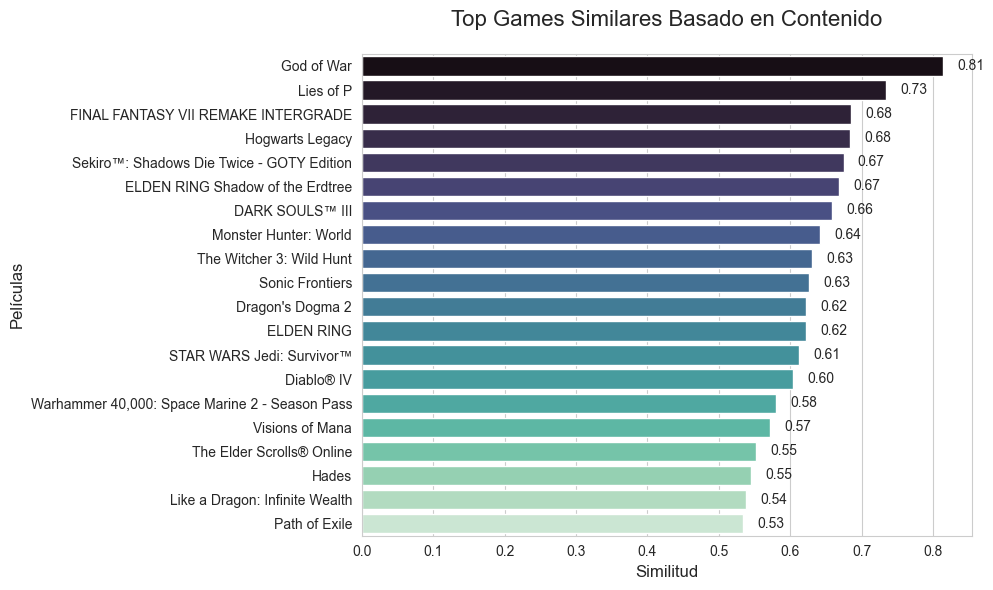

In [34]:
# y ahora buscamos el título
top_simiar_movies = {}
for i in game_similares_ordenadas:
    top_simiar_movies[sr.get_title_from_index(i[0], df_contenido)] = i[1]

# visualizamos los resultados
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Crear gráfico de barras
sns.barplot(
    x=list(top_simiar_movies.values()), 
    y=list(top_simiar_movies.keys()), 
    palette="mako"
)

# Añadir etiquetas y título
plt.title("Top Games Similares Basado en Contenido", fontsize=16, pad=20)
plt.xlabel("Similitud", fontsize=12)
plt.ylabel("Películas", fontsize=12)

# Añadir valores al final de cada barra
for i, value in enumerate(top_simiar_movies.values()):
    plt.text(value + 0.02, i, f"{value:.2f}", va='center', fontsize=10)

plt.tight_layout()
